In [1]:
# --- Célula 1: Importações ---
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

# modelos
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# preprocessamento & split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# métricas
from sklearn.metrics import classification_report, confusion_matrix

# keras
import tensorflow as tf
from tensorflow.keras.models import load_model

2025-10-15 12:57:26.086179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-15 12:57:26.102802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-15 12:57:26.107800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-15 12:57:26.119923: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 12:57:26.913933: W tensorflow/compiler/tf2

In [2]:
# --- Célula 2: Carregamento e seleção de cenário/features ---
path_final_table = Path('../data/processed/modeling_table_final.parquet')
df_completo = pd.read_parquet(path_final_table)

# cenário
sys.path.append('..')
from config import START_YEAR as CONFIG_START_YEAR, START_MONTH as CONFIG_START_MONTH
from config import END_YEAR as CONFIG_END_YEAR, END_MONTH as CONFIG_END_MONTH

CENARIO_ESCOLHIDO = 'pos_2017'
START_YEAR = 2017
nome_cenario = "Ensemble Pós-2017"

# filtro por período (mantém consistência com config)
start_date = pd.Timestamp(year=START_YEAR, month=CONFIG_START_MONTH, day=1)
end_date = pd.Timestamp(year=CONFIG_END_YEAR, month=CONFIG_END_MONTH, day=31)  # safe upper bound
df = df_completo.loc[start_date:end_date].copy()

# grupos de features (mesmos que você usou)
features_hidrica = ['ear_percentual_seco', 'ena_percentual_mlt_seco']
features_adicionais = ['cmo_semanal_seco', 'disponibilidade_total_diaria_go', 'indicador_ccal_mensal']
features_clima = ['ghi', 'temp2m_c', 'precipitacao_mm']
features_avancadas = ['carga_media_7d','carga_std_7d','geracao_media_7d','ear_ontem','ear_diff_3d','margem_oferta_demanda','pressao_demanda_ear','precip_acumulada_14d','precip_acumulada_30d']
features_calendario = ['mes','dia_da_semana','dia_do_ano']

features_para_teste_nomes = features_hidrica + features_adicionais + features_clima + features_calendario + features_avancadas
features_para_teste = [c for c in features_para_teste_nomes if c in df.columns]

X = df[features_para_teste].copy()
y = df['nivel_risco'].copy()

print(f"Registros após filtro: {df.shape[0]}; features usadas: {len(features_para_teste)}")
print("Distribuição de classes:\n", y.value_counts())

Registros após filtro: 3176; features usadas: 16
Distribuição de classes:
 nivel_risco
baixo    3134
medio      32
alto       10
Name: count, dtype: int64


In [3]:
# --- Célula 3: Split e scaler ---
# mapeamento
mapeamento_risco = {'baixo':0,'medio':1,'alto':2}
y_encoded = y.map(mapeamento_risco)

# split estratificado (mantém comportamento que usou antes em outros notebooks)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# scaler: ajusta no treino, transforma no teste
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# salva o scaler para uso futuro (recomendado)
os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/scaler_ensemble_2017.joblib')
print("Scaler salvo em ../models/scaler_ensemble_2017.joblib")

# informa shapes
print("X_train:", X_train.shape, "X_test:", X_test.shape)

Scaler salvo em ../models/scaler_ensemble_2017.joblib
X_train: (2223, 16) X_test: (953, 16)


In [4]:
# --- Célula 4: Sequências para LSTM (TIME_STEPS) e alinhamento ---
TIME_STEPS = 14  # mesmo que usou no LSTM
def create_sequences_from_array(X_arr, y_arr, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X_arr) - time_steps):
        Xs.append(X_arr[i:(i+time_steps)])
        ys.append(y_arr[i+time_steps])
    return np.array(Xs), np.array(ys)

# Convertendo X_test_scaled (numpy) para sequências
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Para manter alinhamento: cria sequências a partir de dados ordenados por índice (já estão)
X_test_seq, y_test_seq = create_sequences_from_array(X_test_scaled, y_test.values, TIME_STEPS)

# Para modelos de árvore, precisamos das mesmas amostras (dia alvo t) — que correspondem a X_test_scaled[TIME_STEPS:]
X_test_for_trees = X_test_scaled[TIME_STEPS:].copy()
y_test_for_trees = y_test.values[TIME_STEPS:].copy()

print("X_test_seq shape (LSTM):", X_test_seq.shape)
print("X_test_for_trees shape:", X_test_for_trees.shape)
print("y_test_seq shape:", y_test_seq.shape)

X_test_seq shape (LSTM): (939, 14, 16)
X_test_for_trees shape: (939, 16)
y_test_seq shape: (939,)


In [5]:
# --- Célula 5: Carregamento dos modelos ---
# XGBoost
xgb_path = "../models/best_xgboost_model_2017.joblib"
xgb_model = joblib.load(xgb_path)
print("XGBoost carregado:", xgb_path)

# BalancedRandomForest (unbalanced_model nomenclatura antiga)
brf_path = "../models/best_brf_model_2017.joblib"
unbalanced_model = joblib.load(brf_path)
print("BalancedRandomForest carregado:", brf_path)

# LSTM - tenta o nome padrão que salvamos, senão tenta o nome antigo
lstm_paths_to_try = [
    f"../models/best_lstm_model_{CENARIO_ESCOLHIDO}.h5",
    "../models/best_lstm_model_LSTM Pós-2017 (Histórico Intermediário).h5"
]
lstm_model = None
for p in lstm_paths_to_try:
    if Path(p).exists():
        lstm_model = load_model(p)
        print("LSTM carregado:", p)
        break
if lstm_model is None:
    raise FileNotFoundError(f"Nenhum modelo LSTM encontrado em: {lstm_paths_to_try}")

# função auxiliar de previsão LSTM (usa X_test_seq, i.e. formato [samples, timesteps, features])
def predict_lstm_probs(model, X_seq):
    probs = model.predict(X_seq, verbose=0)
    return probs


XGBoost carregado: ../models/best_xgboost_model_2017.joblib
BalancedRandomForest carregado: ../models/best_brf_model_2017.joblib


I0000 00:00:1760543964.508396  230886 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1760543964.548802  230886 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1760543964.549971  230886 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1760543964.552330  230886 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

LSTM carregado: ../models/best_lstm_model_pos_2017.h5


In [6]:
# --- Célula 6: Probabilidades dos 3 modelos (alinhadas) ---

# 1) XGBoost e BRF usam X_test_for_trees (cada linha corresponde ao dia alvo t)
proba_xgb = xgb_model.predict_proba(X_test_for_trees)
proba_unbalanced = unbalanced_model.predict_proba(X_test_for_trees)

print("Probas XGB shape:", proba_xgb.shape)
print("Probas BRF shape:", proba_unbalanced.shape)

# 2) LSTM usa X_test_seq
proba_lstm = predict_lstm_probs(lstm_model, X_test_seq)
print("Probas LSTM shape:", proba_lstm.shape)

# Consistência: os três arrays devem ter o mesmo número de amostras.
n_xgb = proba_xgb.shape[0]
n_brf = proba_unbalanced.shape[0]
n_lstm = proba_lstm.shape[0]
print("n_xgb, n_brf, n_lstm:", n_xgb, n_brf, n_lstm)

# Se houver discrepância (por alguma razão), alinha ao menor n
n_min = min(n_xgb, n_brf, n_lstm)
if n_min < max(n_xgb, n_brf, n_lstm):
    print("Aviso: discrepância de tamanhos. Truncando para o menor tamanho comum:", n_min)
    proba_xgb = proba_xgb[:n_min]
    proba_unbalanced = proba_unbalanced[:n_min]
    proba_lstm = proba_lstm[:n_min]
    # ajusta y de referência também
    y_true = y_test_for_trees[:n_min]
else:
    y_true = y_test_for_trees.copy()
print("y_true shape usada na avaliação:", y_true.shape)

Probas XGB shape: (939, 3)
Probas BRF shape: (939, 3)


2025-10-15 13:00:05.078525: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


Probas LSTM shape: (939, 3)
n_xgb, n_brf, n_lstm: 939 939 939
y_true shape usada na avaliação: (939,)



--- Ensemble (soft voting) - Ensemble Pós-2017 ---
              precision    recall  f1-score   support

       baixo       0.99      0.99      0.99       926
       medio       0.10      0.10      0.10        10
        alto       0.00      0.00      0.00         3

    accuracy                           0.98       939
   macro avg       0.36      0.36      0.36       939
weighted avg       0.97      0.98      0.97       939



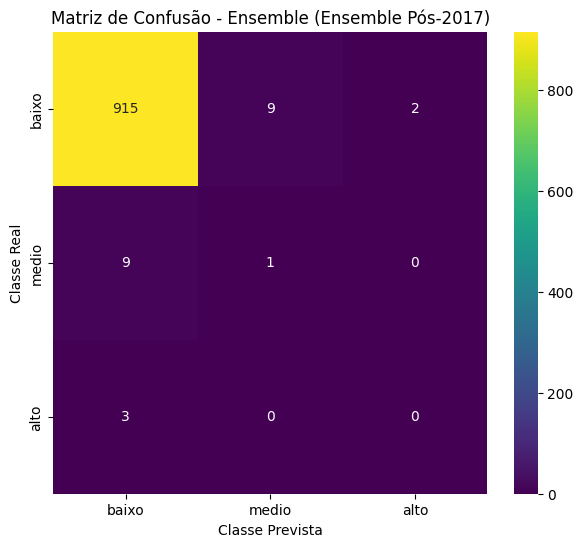

Predições do ensemble salvas em ../models/ensemble_predictions_2017.parquet


In [7]:
# --- Célula 7: Ensemble (soft voting), avaliação e conf matrix ---
# média das probabilidades (soft voting)
proba_ensemble = (proba_xgb + proba_unbalanced + proba_lstm) / 3.0

# predição final
y_pred_ensemble = np.argmax(proba_ensemble, axis=1)

# relatório
print(f"\n--- Ensemble (soft voting) - {nome_cenario} ---")
print(classification_report(y_true, y_pred_ensemble, target_names=mapeamento_risco.keys(), zero_division=0))

# matriz de confusão
cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=mapeamento_risco.keys(), yticklabels=mapeamento_risco.keys())
plt.title(f"Matriz de Confusão - Ensemble ({nome_cenario})")
plt.ylabel("Classe Real"); plt.xlabel("Classe Prevista")
plt.show()

# opcional: salvar probabilidades e preds
out_df = pd.DataFrame({
    'y_true': y_true,
    'pred_ensemble': y_pred_ensemble,
    'proba_xgb_0': proba_xgb[:,0], 'proba_xgb_1': proba_xgb[:,1], 'proba_xgb_2': proba_xgb[:,2],
    'proba_brf_0': proba_unbalanced[:,0], 'proba_brf_1': proba_unbalanced[:,1], 'proba_brf_2': proba_unbalanced[:,2],
    'proba_lstm_0': proba_lstm[:,0], 'proba_lstm_1': proba_lstm[:,1], 'proba_lstm_2': proba_lstm[:,2],
    'proba_ens_0': proba_ensemble[:,0], 'proba_ens_1': proba_ensemble[:,1], 'proba_ens_2': proba_ensemble[:,2],
})
out_df.to_parquet('../models/ensemble_predictions_2017.parquet', index=False)
print("Predições do ensemble salvas em ../models/ensemble_predictions_2017.parquet")